In [1]:
# usual imports
import os
import numpy as np
import matplotlib.pyplot as plt
from rail.core.utils import find_rail_file
from rail.pipelines.examples.survey_nonuniformity.survey_nonuniformity import SurveyNonuniformDegraderPipeline
from rail.core import common_params
from rail.pipelines.utils.name_factory import NameFactory, DataType, CatalogType, ModelType, PdfType
import qp
import ceci

Imported rail.hub
Imported rail.astro_tools
Imported rail.core
Imported rail.stages
Imported rail.bpz
Imported rail.cmnn
Imported rail.delight
Failed to import rail.dsps because: You need to have the SPS_HOME environment variable
Imported rail.flexzboost
Imported rail.gpz
Imported rail.pipelines
Failed to import rail.pzflow because: No module named 'rail.estimation.algos.pzflow'
Imported rail.sklearn
Imported rail.som
Attached 12 base classes and 57 fully formed stages to rail.stages


In [2]:
# other dependencies:
import healpy as hp
import tables_io

### Define the bands, magnitude limits, and put them into a dictionary

In [3]:
bands = 'ugrizy'
maglims = [27.05, 27.79, 29.04, 29.06, 28.62, 27.98]
maglim_dict={}
for band,limx in zip(bands, maglims):
    maglim_dict[f"mag_{band}_lsst"] = limx

### Setting common parameters to all the stages in the estimation


In [4]:
common_params.set_param_defaults(
    bands=[f'mag_{band}_lsst' for band in bands], # bands
    err_bands=[f'mag_err_{band}_lsst' for band in bands], # uncertainty bands
    nondetect_val=np.nan,
    #ref_band='HSCi_cmodel_dered',
    redshift_col='redshift',
    mag_limits=maglim_dict,
    #zmax=6.0, # set zmax to 6 for HSC
)

### Set up the pipeline

In [5]:
pipe = SurveyNonuniformDegraderPipeline()

Inserting handle into data store.  model: /global/u2/q/qhang/desc/rail_base/src/rail/examples_data/goldenspike_data/data/pretrained_flow.pkl, flow_engine_train
Inserting handle into data store.  output_flow_engine_train: catalog/created/inprogress_output_flow_engine_train.pq, flow_engine_train
Inserting handle into data store.  output_obs_condition: catalog/degraded/inprogress_output_obscondition.pq, obs_condition
Inserting handle into data store.  output_col_remapper: catalog/degraded/inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_deredden: catalog/degraded/inprogress_output_deredden.pq, deredden
Inserting handle into data store.  output_table_conv: catalog/degraded/inprogress_output_table_conv.hdf5, table_conv
Inserting handle into data store.  model_inform_bpz: model/estimator/inprogress_trained_BPZ.pkl, inform_bpz
Inserting handle into data store.  output_estimate_bpz: pdf/pz/inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [6]:
namer = NameFactory()

### Preparing input files

In [9]:
# fetch dust map and save:
import dustmaps.sfd
dustmaps.sfd.fetch()

 62.3 MiB of 64.0 MiB |  34.8 MiB/s |################## |  97% | ETA:   0:00:00

 64.0 MiB of 64.0 MiB |  31.6 MiB/s |###################| 100% | ETA:  00:00:00

Here, we will create a set of dummy coadd depth maps covering the DC2 area.
We will set the five-sigma depth roughly corresponds to mode of Y1. Pixels with $RA<62$ has a depth 1 magnitude shallower than $RA\geq62$.

In [39]:
# load the DC2 mask:
mask = hp.read_map(find_rail_file("examples_data/creation_data/data/survey_conditions/DC2-mask-neg-nside-128.fits"))
mask[mask<0]=0

m5={
    "u":[23.80, 24.80],
    "g":[25.20, 26.20],
    "r":[25.25, 26.25],
    "i":[24.50, 25.50],
    "z":[24.20, 25.20],
    "y":[23.25, 24.25],
   }

nside=hp.get_nside(mask)
for mm in m5.keys():
    ipix=np.arange(len(mask))[mask.astype(bool)]
    ra, dec=hp.pix2ang(nside,ipix,lonlat=True)
    out=np.copy(mask)
    out[ipix[ra<62]]=m5[mm][0]
    out[ipix[ra>=62]]=m5[mm][1]
    # save them in the current directory:
    hp.write_map(f"CoaddM5_{mm}_dummpy.fits", out, overwrite=True)

setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]
setting the output map dtype to [dtype('>f8')]


### Define parameters for each stage

In [7]:
# dictionary used by ObsCondition
# first define a set of input map directories:
# nside of maps
nside=128

# coadd depth maps:
coaddm5_u = "./CoaddM5_u_dummpy.fits"
coaddm5_g = "./CoaddM5_g_dummpy.fits"
coaddm5_r = "./CoaddM5_r_dummpy.fits"
coaddm5_i = "./CoaddM5_i_dummpy.fits"
coaddm5_z = "./CoaddM5_z_dummpy.fits"
coaddm5_y = "./CoaddM5_y_dummpy.fits"

# here we will set the observing year and number of visits per year to 1, because we are supplying coadd depth

# mask:
maskdir = find_rail_file("examples_data/creation_data/data/survey_conditions/DC2-mask-neg-nside-128.fits")

# weight: for now we supply uniform weight

band_dict={
    "u": "mag_u_lsst",
    "g": "mag_g_lsst",
    "r": "mag_r_lsst",
    "i": "mag_i_lsst",
    "z": "mag_z_lsst",
    "y": "mag_y_lsst",
}

map_dict={
        "m5": {
            "u": coaddm5_u,
            "g": coaddm5_g,
            "r": coaddm5_r,
            "i": coaddm5_i,
            "z": coaddm5_z,
            "y": coaddm5_y,
        },
        "nYrObs": 1.,
        "nVisYr": {
            "u": 1.,
            "g": 1.,
            "r": 1.,
            "i": 1.,
            "z": 1.,
            "y": 1., 
        },
        "sigLim": 3,
        "ndFlag": np.nan,
        "extendedType": "point", # not doing extended error here because no size info.
                                 # if use extended errors, you might also want to supply
                                 # PSF/seeing maps
        "majorCol": "major",
        "minorCol": "minor",
        "decorrelate": True,
        "highSNR": False,
        "renameDict": band_dict,  
    }

In [12]:
pipe.flow_engine_train.config.update(n_samples=200)
pipe.obs_condition.config.update(map_dict=map_dict, nside=nside, mask = maskdir, weight = "",)
pipe.deredden.config.update(dustmap_dir=".", copy_all_cols=True)# where to save the dust map downloaded
pipe.estimate_bpz.config.update(spec_groupname = "", redshift_colname = 'redshift', prior_band='i')
pipe.tomopraphy.config.update(nbins=3,)# uniform binning between [0,3], 3 bins

In [13]:
from rail.core.utils import RAILDIR
flow_file = os.path.join(RAILDIR, 'rail/examples_data/goldenspike_data/data/pretrained_flow.pkl')
pipe_info = pipe.initialize(dict(model=flow_file), dict(output_dir='.', log_dir='.', resume=True), None)

In [14]:
pipe_info

(({'flow_engine_train': <Job flow_engine_train>,
   'obs_condition': <Job obs_condition>,
   'col_remapper': <Job col_remapper>,
   'deredden': <Job deredden>,
   'table_conv': <Job table_conv>,
   'inform_bpz': <Job inform_bpz>,
   'estimate_bpz': <Job estimate_bpz>,
   'tomopraphy': <Job tomopraphy>},
   Loaded observing conditions from configuration file: 
   nside = 128, 
   mask file:  /global/u2/q/qhang/desc/rail_astro_tools/src/rail/examples_data/creation_data/data/survey_conditions/DC2-mask-neg-nside-128.fits, 
   weight file:  , 
   tot_nVis_flag = True, 
   random_seed = 42, 
   map_dict contains the following items: 
   {'m5': {'u': './CoaddM5_u_dummpy.fits', 'g': './CoaddM5_g_dummpy.fits', 'r': './CoaddM5_r_dummpy.fits', 'i': './CoaddM5_i_dummpy.fits', 'z': './CoaddM5_z_dummpy.fits', 'y': './CoaddM5_y_dummpy.fits'}, 'nYrObs': 1.0, 'nVisYr': {'u': 1.0, 'g': 1.0, 'r': 1.0, 'i': 1.0, 'z': 1.0, 'y': 1.0}, 'sigLim': 3, 'ndFlag': nan, 'extendedType': 'point', 'majorCol': 'major',

### Save the pipeline into a yml file

In [15]:
pipe.save('tmp_survey_nonuniformity.yml')

### run pipeline

In [1]:
import ceci
pr = ceci.Pipeline.read('tmp_survey_nonuniformity.yml')

Inserting handle into data store.  model: /global/u2/q/qhang/desc/rail_base/src/rail/examples_data/goldenspike_data/data/pretrained_flow.pkl, flow_engine_train


In [3]:
pr.run() # this somehow is not using the rail_dev environment to run


Executing flow_engine_train
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/global/u2/q/qhang/desc/rail_base/src/rail/examples_data/goldenspike_data/data/pretrained_flow.pkl   --name=flow_engine_train   --config=tmp_survey_nonuniformity_config.yml   --output=./catalog/created/output_flow_engine_train.pq 
Output writing to ./flow_engine_train.out

Job flow_engine_train has failed with status 1



*************************************************
Error running pipeline stage flow_engine_train.

Standard output and error streams in ./flow_engine_train.out
*************************************************


1

### *If you are running this on nersc:* 

Better use command line as Jupyter notebook may fail:

```
ceci tmp_survey_nonuniformity.yml
```

You need to set name of `site: name:` to `local` or `nersc` in `tmp_survey_nonuniformity.yml`. 

You might want to require an interactive node for the `flowEngine` to work (takes about 2.5G memory):

```
salloc --nodes 1 --qos interactive --time 00:10:00 --constraint cpu
```

# Check n(z) in tomographic bins with depth:

In [40]:
# load the tomographic bins:
ftomo=tables_io.read("./pdf/pz/output_tomography.hdf5")
tomo=ftomo['class_id']
objid=ftomo['row_index']

In [45]:
# load the object ra, dec:
fobj=tables_io.read("./catalog/degraded/output_table_conv.hdf5")
ra=fobj['ra']
redshift=fobj['redshift']
magi=fobj['mag_i_lsst']
magi_err=fobj['mag_err_i_lsst']

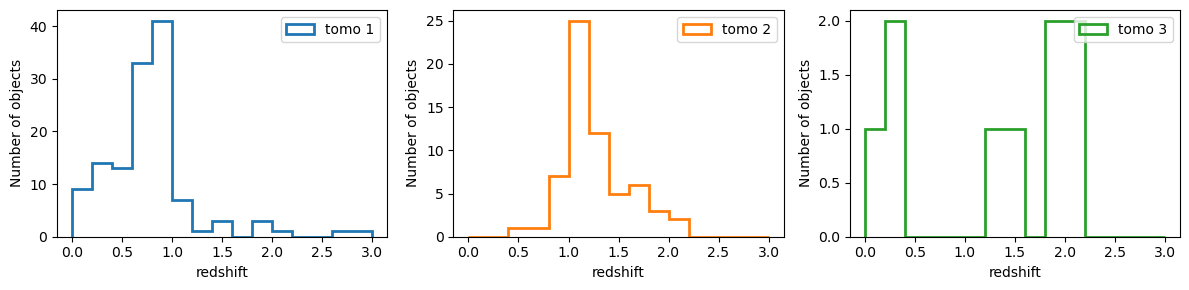

In [67]:
# total:
fig,axarr=plt.subplots(1,3,figsize=[12,3])
for ii in range(3):
    ind1=tomo==(ii+1)
    plt.sca(axarr[ii])
    cc=plt.hist(redshift[ind1], bins=15, range=[0,3],label=f'tomo {ii+1}', 
                histtype='step',color=f'C{ii}', lw=2)
    plt.legend(loc='upper right')
    plt.xlabel("redshift")
    plt.ylabel("Number of objects")
plt.tight_layout()

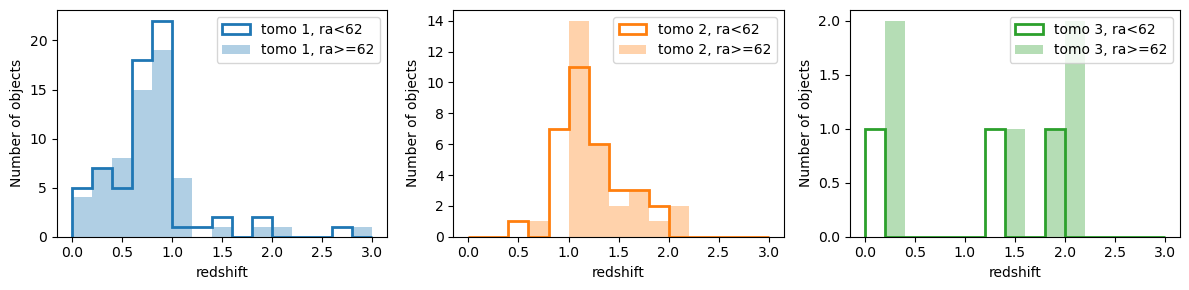

In [65]:
# now also split in depth:
fig,axarr=plt.subplots(1,3,figsize=[12,3])
for ii in range(3):
    ind1=tomo==(ii+1)
    ind2=ra<62
    plt.sca(axarr[ii])
    cc=plt.hist(redshift[ind1*ind2], bins=15, range=[0,3],label=f'tomo {ii+1}, ra<62', 
                histtype='step',color=f'C{ii}', lw=2)
    cc=plt.hist(redshift[ind1*(~ind2)], bins=15, range=[0,3],label=f'tomo {ii+1}, ra>=62', 
                color=f'C{ii}', alpha=0.35)
    plt.legend()
    plt.xlabel("redshift")
    plt.ylabel("Number of objects")
plt.tight_layout()

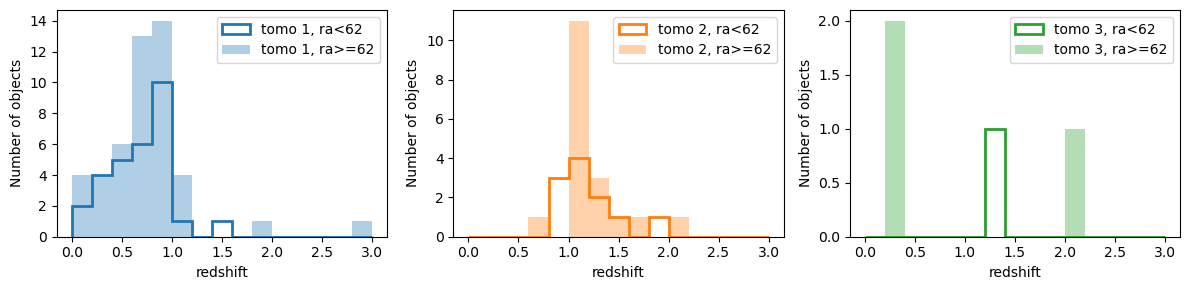

In [64]:
# if we select sample with higher snr and i-band magnitude limit:
# compute snr:
snr=1/(10**(magi_err/2.5)-1)
ind3=snr>8

# magnitude limit:
ind4=magi<24.5

fig,axarr=plt.subplots(1,3,figsize=[12,3])
for ii in range(3):
    ind1=tomo==(ii+1)
    ind2=ra<62
    plt.sca(axarr[ii])
    cc=plt.hist(redshift[ind1*ind2*ind3*ind4], bins=15, range=[0,3],label=f'tomo {ii+1}, ra<62', 
                histtype='step',color=f'C{ii}', lw=2)
    cc=plt.hist(redshift[ind1*(~ind2)*ind3*ind4], bins=15, range=[0,3],label=f'tomo {ii+1}, ra>=62', 
                color=f'C{ii}', alpha=0.35)
    plt.legend()
    plt.xlabel("redshift")
    plt.ylabel("Number of objects")
plt.tight_layout()

We see that given a SNR cut of 8 and i-band magnitude cut at 24.5, we find more, higher redshift objects in the deeper pixels, as expected.